In [35]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
# %matplotlib inline
import matplotlib_inline
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import datetime as datetime
import re

In [36]:
def parse_datetime(date):
    date_stripped = re.sub(r'(\.\d{6})\d+', r'\1', date)
    return pd.to_datetime(date_stripped)

# accidents = pd.read_csv('US_Accidents_March23.csv')
accidents = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
accidents = accidents.drop(['ID', 'Source', 'End_Lat', 'End_Lng', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp'], axis=1)
accidents['Start_Time'] = accidents['Start_Time'].apply(parse_datetime)
accidents['End_Time'] = accidents['End_Time'].apply(parse_datetime)
accidents["Duration"] = ((accidents["End_Time"] - accidents["Start_Time"]).dt.total_seconds() // 60).astype(int)
accidents = accidents.dropna(how='any')

In [37]:
# Function to convert to light level (Option B)
def twilight_to_level(row):
    return (
        (row['Astronomical_Twilight'] == 'Day') * 1 +
        (row['Nautical_Twilight'] == 'Day') * 1 +
        (row['Civil_Twilight'] == 'Day') * 1 +
        (row['Sunrise_Sunset'] == 'Day') * 1
    )

# Apply transformation
accidents['Light_Level'] = accidents.apply(twilight_to_level, axis=1)
accidents = accidents.drop(['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'End_Time'], axis=1)
accidents

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Duration,Light_Level
0,2,2019-06-12 10:10:56,30.641211,-91.153481,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,Zachary,East Baton Rouge,LA,...,False,False,False,False,False,False,True,False,45,4
1,2,2022-12-03 23:37:14,38.990562,-77.399070,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,Sterling,Loudoun,VA,...,False,False,False,False,False,False,False,False,139,0
2,2,2022-08-20 13:13:00,34.661189,-120.492822,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,Lompoc,Santa Barbara,CA,...,False,False,False,False,False,False,True,False,129,4
3,2,2022-02-21 17:43:04,43.680592,-92.993317,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,Austin,Mower,MN,...,False,False,False,False,False,False,False,False,120,4
4,2,2020-12-04 01:46:00,35.395484,-118.985176,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,Bakersfield,Kern,CA,...,False,False,False,False,False,False,False,False,147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2,2021-12-15 07:30:00,45.522510,-123.084104,0.158,Stationary traffic on OR-47 from NW Martin Rd ...,Quince St,Forest Grove,Washington,OR,...,False,False,False,False,False,False,False,False,20,3
499996,2,2021-12-19 16:25:00,26.702570,-80.111169,0.040,Incident on MILITARY TRL near WESTGATE AVE Dri...,N Military Trl,West Palm Beach,Palm Beach,FL,...,False,False,False,False,False,False,False,False,75,4
499997,2,2022-04-13 19:28:29,34.561862,-112.259620,0.549,Crash on the right shoulder on E SR-69 Northbo...,E AZ-69,Dewey,Yavapai,AZ,...,False,False,False,False,False,False,True,False,125,2
499998,3,2020-05-15 17:20:56,38.406680,-78.619310,0.000,At US-340/S Stuart Ave - Serious accident.,W Spotswood Trl,Elkton,Rockingham,VA,...,False,False,False,False,False,False,True,False,30,4


In [38]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336980 entries, 0 to 499999
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Severity           336980 non-null  int64         
 1   Start_Time         336980 non-null  datetime64[ns]
 2   Start_Lat          336980 non-null  float64       
 3   Start_Lng          336980 non-null  float64       
 4   Distance(mi)       336980 non-null  float64       
 5   Description        336980 non-null  object        
 6   Street             336980 non-null  object        
 7   City               336980 non-null  object        
 8   County             336980 non-null  object        
 9   State              336980 non-null  object        
 10  Zipcode            336980 non-null  object        
 11  Temperature(F)     336980 non-null  float64       
 12  Wind_Chill(F)      336980 non-null  float64       
 13  Humidity(%)        336980 non-null  float64      

In [42]:
accidents.describe()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Duration,Light_Level
count,336980.000000,336980,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,336980.000000,3.369800e+05,336980.000000
mean,2.148650,2021-05-20 18:44:50.666902784,36.165436,-94.222049,0.667878,61.335554,60.016037,64.911066,29.353443,9.018946,7.373985,0.006043,5.312859e+02,2.978111
min,1.000000,2016-01-14 20:18:33,24.562117,-124.497420,0.000000,-29.000000,-52.000000,1.000000,19.360000,0.000000,0.000000,0.000000,2.000000e+00,0.000000
25%,2.000000,2020-07-25 09:57:09.750000128,33.349409,-117.125839,0.000000,48.000000,47.000000,48.000000,29.180000,10.000000,3.000000,0.000000,4.900000e+01,2.000000
50%,2.000000,2021-07-18 12:14:12,35.839081,-86.788754,0.096000,64.000000,64.000000,67.000000,29.680000,10.000000,7.000000,0.000000,7.900000e+01,4.000000
75%,2.000000,2022-04-26 05:42:27,40.128851,-80.294666,0.640000,76.000000,76.000000,84.000000,29.950000,10.000000,10.000000,0.000000,1.280000e+02,4.000000
max,4.000000,2023-03-31 22:46:13,48.999569,-67.484130,149.690000,196.000000,196.000000,100.000000,31.080000,100.000000,243.000000,9.960000,1.578299e+06,4.000000
std,0.444017,NaN,5.185900,17.360866,1.858788,19.174674,21.424033,22.825948,1.105063,2.636280,5.469268,0.046615,1.460355e+04,1.608428


/var/folders/4x/fcr05hgd52n0wldp718_2lpm0000gn/T/ipykernel_35481/382871946.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Severity", data=accidents, palette="coolwarm", ax=axes[0,0])


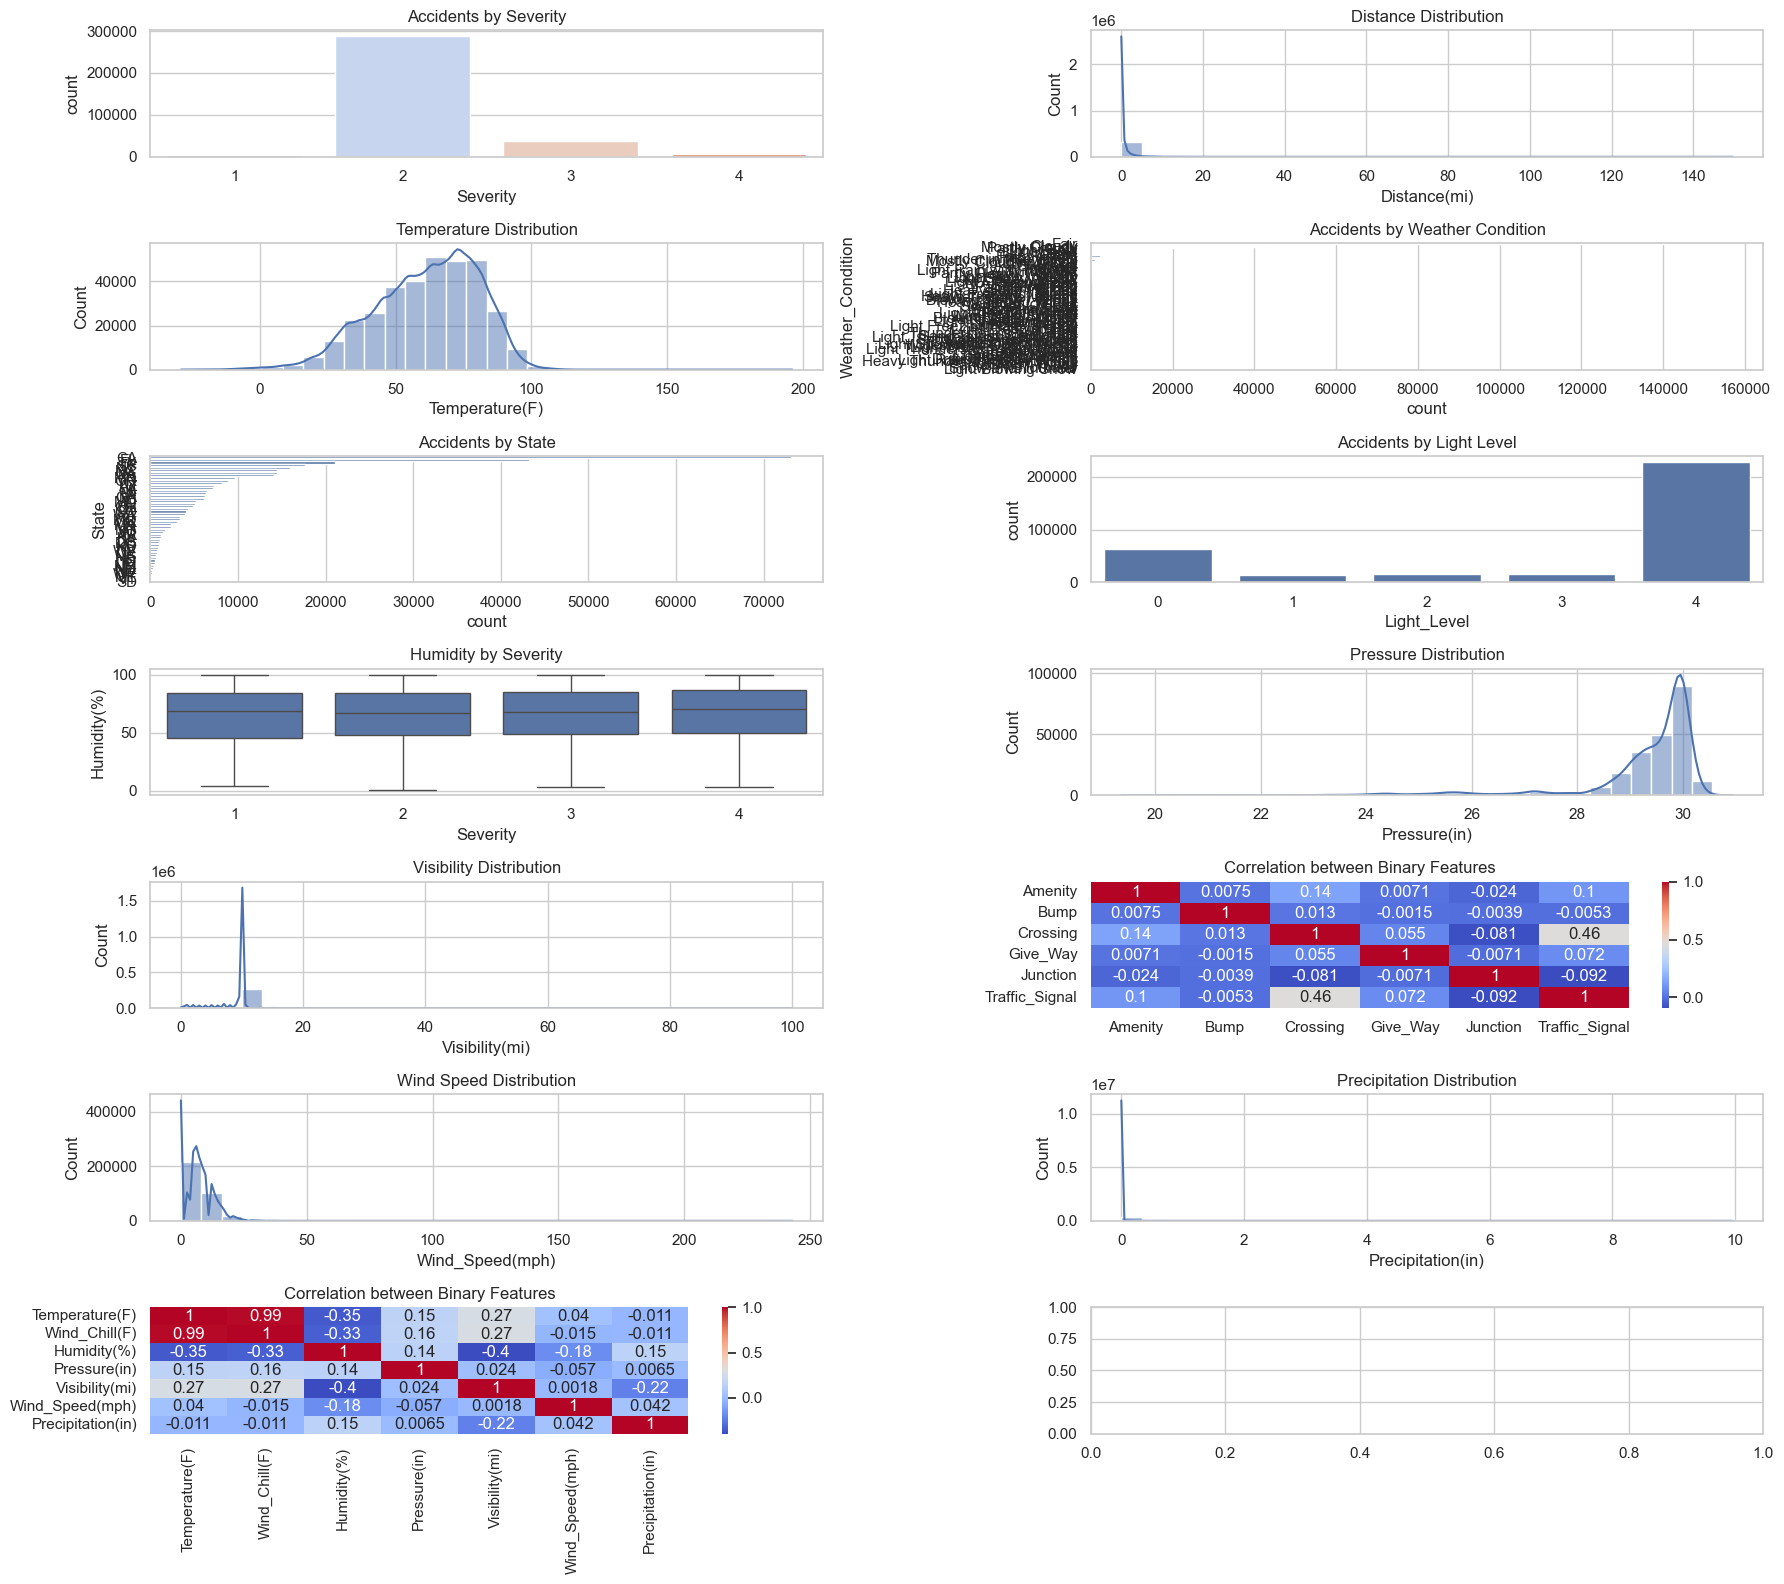

In [41]:
# EDA Plots
fig, axes = plt.subplots(7, 2, figsize=(18, 16))

# 1. Severity distribution
sns.countplot(x="Severity", data=accidents, palette="coolwarm", ax=axes[0,0])
axes[0,0].set_title("Accidents by Severity")

# 2. Distance distribution
sns.histplot(accidents["Distance(mi)"], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distance Distribution")

# 3. Temperature distribution
sns.histplot(accidents["Temperature(F)"], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Temperature Distribution")

# 4. Weather condition counts
sns.countplot(y="Weather_Condition", data=accidents, order=accidents["Weather_Condition"].value_counts().index, ax=axes[1,1])
axes[1,1].set_title("Accidents by Weather Condition")

# 5. State-wise accident count
sns.countplot(y="State", data=accidents, order=accidents["State"].value_counts().index, ax=axes[2,0])
axes[2,0].set_title("Accidents by State")

# 6. Light level distribution
sns.countplot(x="Light_Level", data=accidents, ax=axes[2,1])
axes[2,1].set_title("Accidents by Light Level")

# 7. Humidity vs Severity
sns.boxplot(x="Severity", y="Humidity(%)", data=accidents, ax=axes[3,0])
axes[3,0].set_title("Humidity by Severity")

# 8. Pressure distribution
sns.histplot(df["Pressure(in)"], bins=30, kde=True, ax=axes[3,1])
axes[3,1].set_title("Pressure Distribution")

# 9. Visibility distribution
sns.histplot(accidents["Visibility(mi)"], bins=30, kde=True, ax=axes[4,0])
axes[4,0].set_title("Visibility Distribution")

# 10. Binary feature heatmap
binary_cols = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "Traffic_Signal"]
binary_corr = accidents[binary_cols].corr()
sns.heatmap(binary_corr, annot=True, cmap="coolwarm", ax=axes[4,1])
axes[4,1].set_title("Correlation between Binary Features")

# 11. Wind speed distribution
sns.histplot(accidents["Wind_Speed(mph)"], bins=30, kde=True, ax=axes[5,0])
axes[5,0].set_title("Wind Speed Distribution")

# 12. Precipitation distribution
sns.histplot(accidents["Precipitation(in)"], bins=30, kde=True, ax=axes[5,1])
axes[5,1].set_title("Precipitation Distribution")

# 13. Binary feature heatmap
binary_cols = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
binary_corr = accidents[binary_cols].corr()
sns.heatmap(binary_corr, annot=True, cmap="coolwarm", ax=axes[6,0])
axes[6,0].set_title("Correlation between Binary Features")

plt.tight_layout()

Text(0, 0.5, 'Latitude')

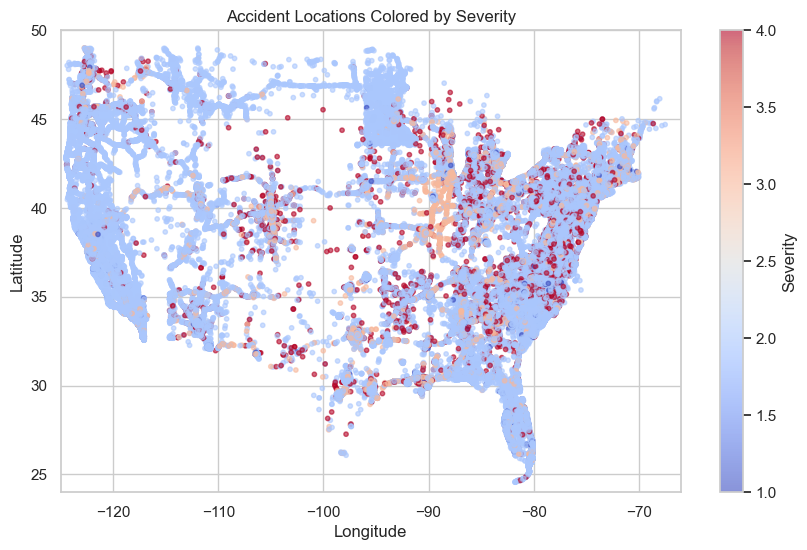

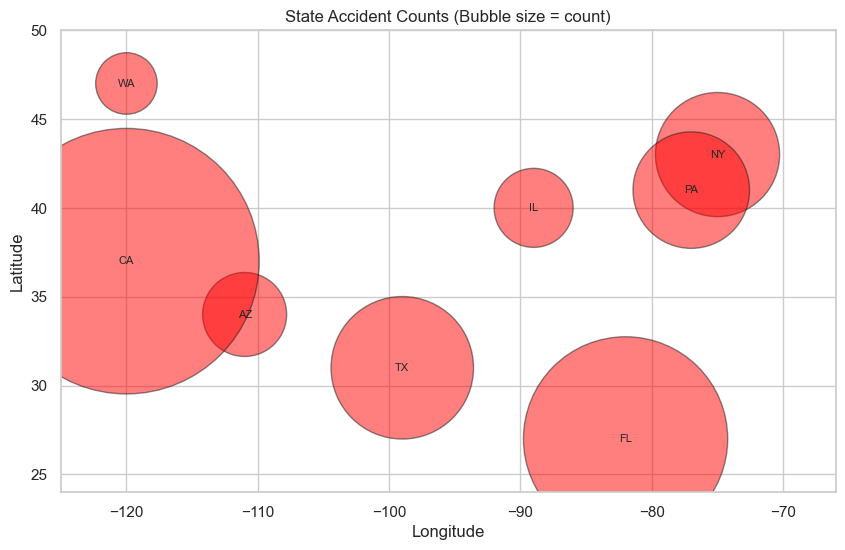

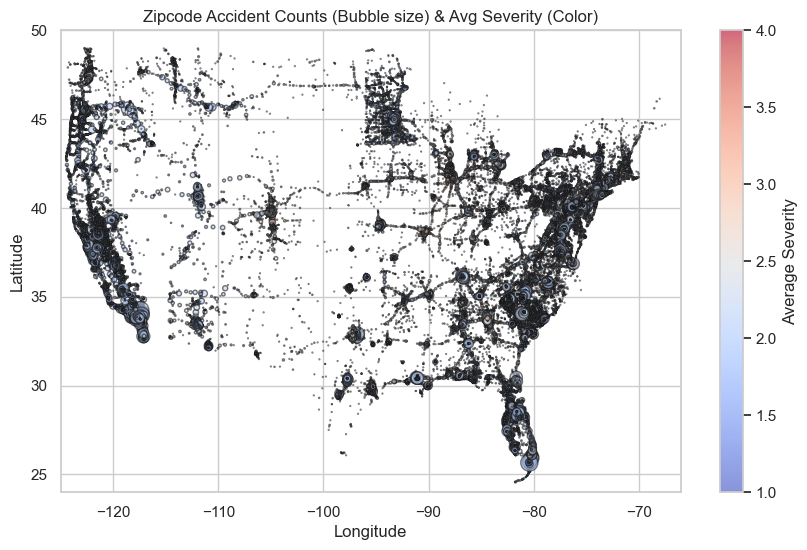

In [23]:
# ------------------
# 2) Scatterplot of lat/lon colored by severity
# ------------------
fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(accidents["Start_Lng"], accidents["Start_Lat"], 
                c=accidents["Severity"], cmap="coolwarm", alpha=0.6, s=10)
plt.colorbar(sc, ax=ax, label="Severity")
ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)
ax.set_title("Accident Locations Colored by Severity")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ------------------
# 3) State-level bubble chart
# ------------------
state_counts = accidents.groupby("State").size().reset_index(name="Count")
state_lats = {"CA":37, "TX":31, "FL":27, "NY":43, "IL":40, "AZ":34, "PA":41, "WA":47}
state_lngs = {"CA":-120, "TX":-99, "FL":-82, "NY":-75, "IL":-89, "AZ":-111, "PA":-77, "WA":-120}
state_counts["Lat"] = state_counts["State"].map(state_lats)
state_counts["Lng"] = state_counts["State"].map(state_lngs)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(state_counts["Lng"], state_counts["Lat"], 
           s=state_counts["Count"]/2, color="red", alpha=0.5, edgecolor="k")
for _, row in state_counts.iterrows():
    ax.text(row["Lng"], row["Lat"], row["State"], ha="center", va="center", fontsize=8)
ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)
ax.set_title("State Accident Counts (Bubble size = count)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ------------------
# 4) Zipcode bubble chart
# ------------------
# zip_group = accidents.groupby("Zipcode").agg(
#     Count=("Zipcode", "size"),
#     Lat=("Start_Lat", "mean"),
#     Lng=("Start_Lng", "mean"),
#     AvgSeverity=("Severity", "mean")
# ).reset_index()

# fig, ax = plt.subplots(figsize=(10,6))
# bubble = ax.scatter(zip_group["Lng"], zip_group["Lat"], 
#                     s=zip_group["Count"]/3, 
#                     c=zip_group["AvgSeverity"], cmap="coolwarm", alpha=0.6, edgecolor="k")
# plt.colorbar(bubble, ax=ax, label="Average Severity")
# ax.set_xlim(-125, -66)
# ax.set_ylim(24, 50)
# ax.set_title("Zipcode Accident Counts (Bubble size) & Avg Severity (Color)")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

In [60]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from sklearn.cluster import DBSCAN

# --------------------------
# CONFIG
# --------------------------
LAT_COL = "Start_Lat"
LON_COL = "Start_Lng"
SEVERITY_COL = "Severity"
START_TIME_COL = "Start_Time"
END_TIME_COL = "End_Time"

CRS_WGS84 = "EPSG:4326"
CRS_LOCAL = "EPSG:32139"  # Texas Central (meters) – good for Austin

DBSCAN_EPS_M = 300       # 300 meters
DBSCAN_MIN_SAMPLES = 10

M_PER_MILE = 1609.344
CELL_SIZE_M = M_PER_MILE # 1x1 mile

# --------------------------
# HELPERS
# --------------------------
def parse_times(df):
    for c in [START_TIME_COL, END_TIME_COL]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    if START_TIME_COL in df.columns and END_TIME_COL in df.columns:
        df["Duration_min"] = (df[END_TIME_COL] - df[START_TIME_COL]).dt.total_seconds() / 60.0
    return df

def temporal_features(df):
    t = df[START_TIME_COL]
    df["Hour"] = t.dt.hour
    df["DoW"] = t.dt.dayofweek
    df["Month"] = t.dt.month
    df["Weekend"] = (df["DoW"] >= 5).astype(int)
    df["Rush_AM"] = ((df["Hour"] >= 7) & (df["Hour"] <= 9)).astype(int)
    df["Rush_PM"] = ((df["Hour"] >= 16) & (df["Hour"] <= 18)).astype(int)
    df["Rush_Any"] = ((df["Rush_AM"] == 1) | (df["Rush_PM"] == 1)).astype(int)
    df["Season"] = np.select(
        [
            df["Month"].isin([12,1,2]),
            df["Month"].isin([3,4,5]),
            df["Month"].isin([6,7,8]),
            df["Month"].isin([9,10,11]),
        ],
        ["Winter","Spring","Summer","Fall"],
        default="Unknown"
    )
    df["Hour_sin"] = np.sin(2*np.pi*df["Hour"]/24)
    df["Hour_cos"] = np.cos(2*np.pi*df["Hour"]/24)
    df["Month_sin"] = np.sin(2*np.pi*df["Month"]/12)
    df["Month_cos"] = np.cos(2*np.pi*df["Month"]/12)
    return df

def weather_flags(df):
    wc = df.get("Weather_Condition", pd.Series("", index=df.index)).str.lower().fillna("")
    df["Weather_Rain"] = wc.str.contains("rain|drizzle|shower").astype(int)
    df["Weather_Snow"] = wc.str.contains("snow|sleet|blizzard").astype(int)
    df["Weather_Fog"]  = wc.str.contains("fog|mist|haze").astype(int)
    df["Weather_Storm"]= wc.str.contains("storm|thunder|tstm").astype(int)
    df["Weather_Wind"] = wc.str.contains("wind").astype(int)
    df["Low_Visibility"] = (df.get("Visibility(mi)", np.nan) < 1.0).astype(int)
    df["High_Wind"]      = (df.get("Wind_Speed(mph)", np.nan) >= 25).astype(int)
    df["High_Precip"]    = (df.get("Precipitation(in)", np.nan) >= 0.1).astype(int)
    return df

def poi_features(df):
    poi_cols = [
        "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
        "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
    ]
    for c in poi_cols:
        if c in df.columns:
            df[c] = df[c].astype(int)
    df["POI_Count"] = df[[c for c in poi_cols if c in df.columns]].sum(axis=1)
    df["Signalized_Intersection"] = ((df.get("Junction",0)==1) & (df.get("Traffic_Signal",0)==1)).astype(int)
    return df

def interaction_features(df):
    df["Impact_Score"] = df.get(SEVERITY_COL, 1) * df.get("Duration_min", 0)
    df["Log_Duration"] = np.log1p(df.get("Duration_min", 0).clip(lower=0))
    df["Log_Distance"] = np.log1p(df.get("Distance(mi)", 0).clip(lower=0))
    df["Rush_and_Rain"] = ((df.get("Rush_Any",0)==1) & (df.get("Weather_Rain",0)==1)).astype(int)
    return df

def make_grid(bounds, cell_size_m, crs):
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)
    cells = [box(x, y, x + cell_size_m, y + cell_size_m) for x in xs[:-1] for y in ys[:-1]]
    return gpd.GeoDataFrame(geometry=cells, crs=crs)

# --------------------------
# MAIN PIPELINE FUNCTION
# --------------------------
def engineer_accident_features(accidents):
    df = accidents.copy()
    df = parse_times(df)
    df = temporal_features(df)
    df = weather_flags(df)
    df = poi_features(df)
    df = interaction_features(df)

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[LON_COL], df[LAT_COL]),
        crs=CRS_WGS84
    )
    gdf_m = gdf.to_crs(CRS_LOCAL)

    X = np.c_[gdf_m.geometry.x, gdf_m.geometry.y]
    db = DBSCAN(eps=DBSCAN_EPS_M, min_samples=DBSCAN_MIN_SAMPLES)
    gdf_m["DBSCAN_Cluster"] = db.fit_predict(X)

    grid = make_grid(gdf_m.total_bounds, CELL_SIZE_M, CRS_LOCAL)
    join = gpd.sjoin(gdf_m[[SEVERITY_COL, "geometry"]], grid, how="left", predicate="within")
    counts = join.groupby("index_right").size().rename("Accident_Count")
    grid["Accident_Count"] = counts.reindex(range(len(grid))).fillna(0).astype(int)

    if SEVERITY_COL in gdf_m.columns:
        sev_sum = join.groupby("index_right")[SEVERITY_COL].sum().rename("Severity_Sum")
        grid["Severity_Sum"] = sev_sum.reindex(range(len(grid))).fillna(0)

    return gdf_m.to_crs(CRS_WGS84), grid.to_crs(CRS_WGS84), gdf

# --------------------------
# USAGE
# --------------------------
accidents_fe, grid_gdf, points_gdf = engineer_accident_features(accidents)

print(accidents_fe.head())
print(grid_gdf.head())


                ID   Source  Severity          Start_Time            End_Time  \
3402762  A-3412645  Source1         3 2016-02-08 00:37:08 2016-02-08 06:37:08   
3402767  A-3412650  Source1         3 2016-02-08 07:53:43 2016-02-08 13:53:43   
3402771  A-3412654  Source1         2 2016-02-08 11:51:46 2016-02-08 17:51:46   
3402773  A-3412656  Source1         2 2016-02-08 15:16:43 2016-02-08 21:16:43   
3402774  A-3412657  Source1         2 2016-02-08 15:43:50 2016-02-08 21:43:50   

         Start_Lat  Start_Lng    End_Lat    End_Lng  Distance(mi)  ...  \
3402762  40.108910 -83.092860  40.112060 -83.031870         3.230  ...   
3402767  39.172393 -84.492792  39.170476 -84.501798         0.500  ...   
3402771  41.375310 -81.820170  41.367860 -81.821740         0.521  ...   
3402773  40.109310 -82.968490  40.110780 -82.984000         0.826  ...   
3402774  39.192880 -84.477230  39.196150 -84.473350         0.307  ...   

        High_Wind High_Precip POI_Count Signalized_Intersection Impa

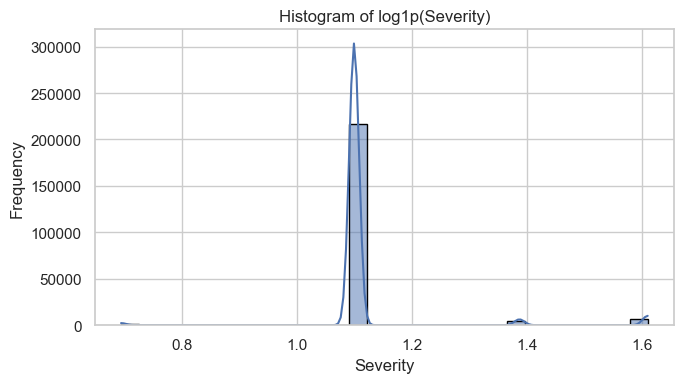

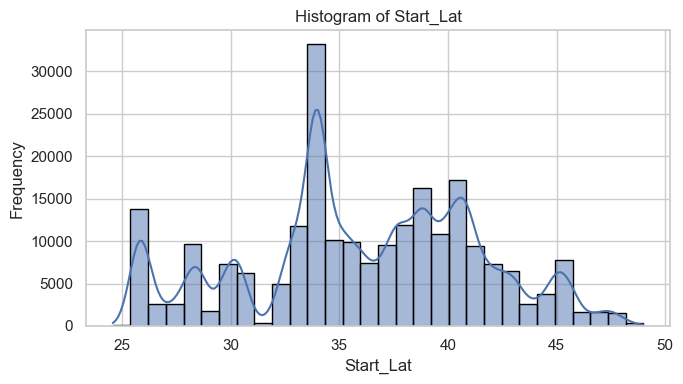

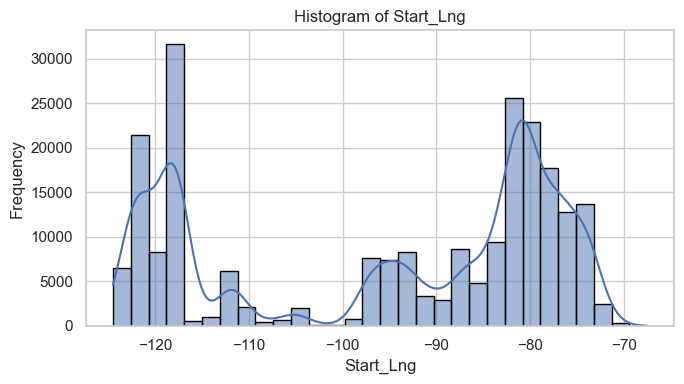

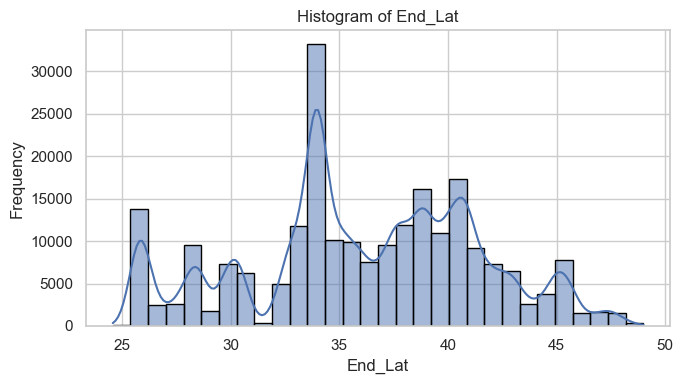

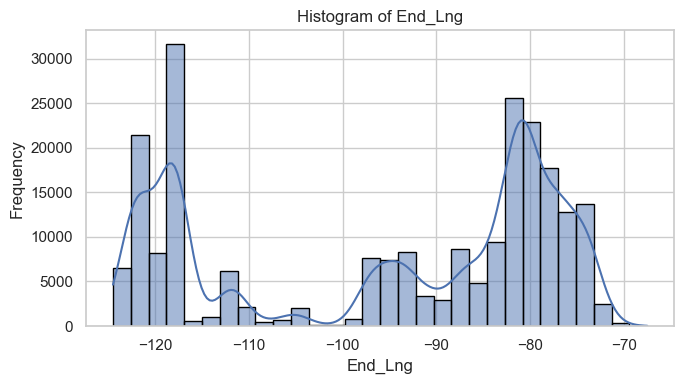

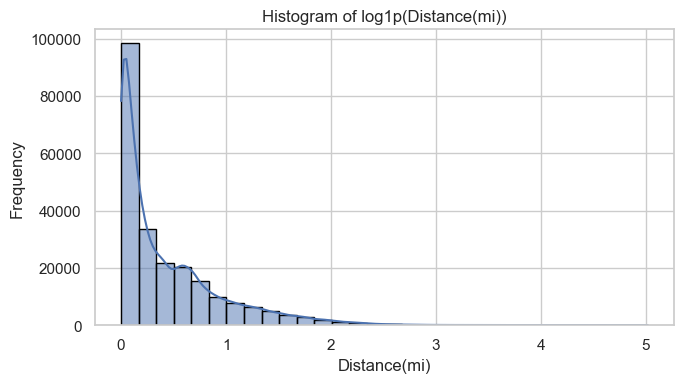

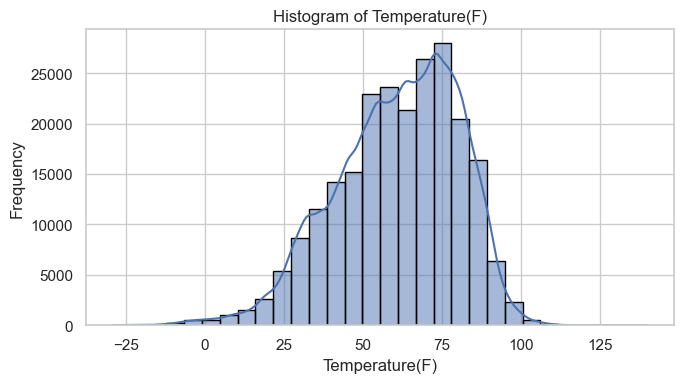

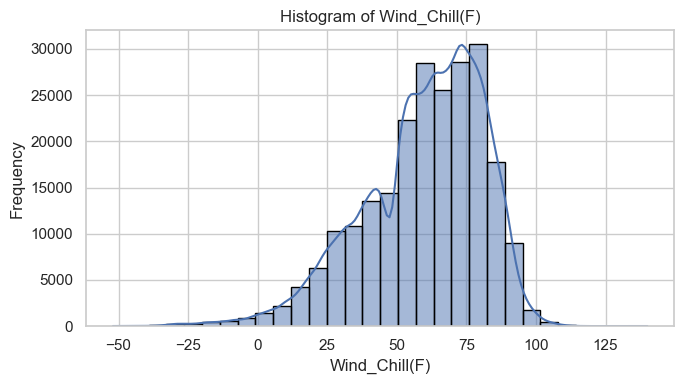

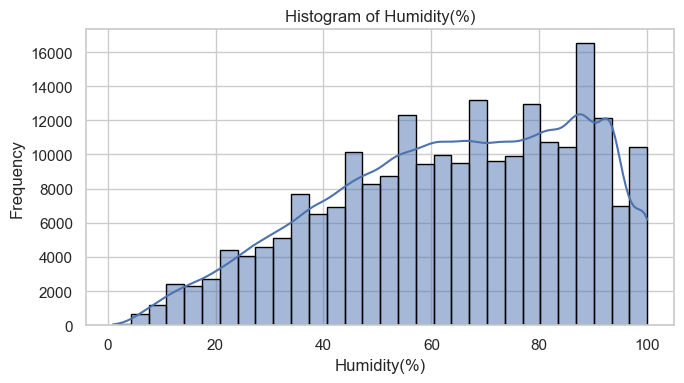

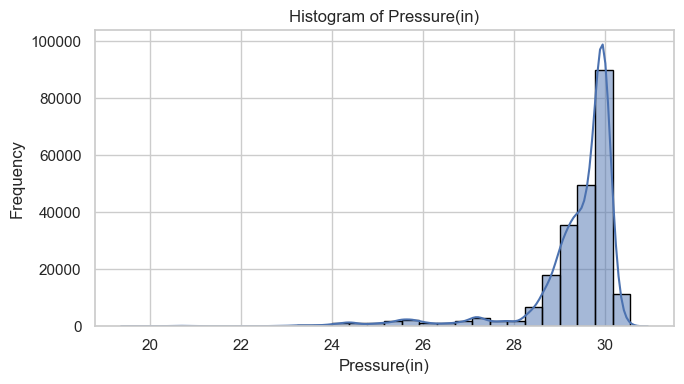

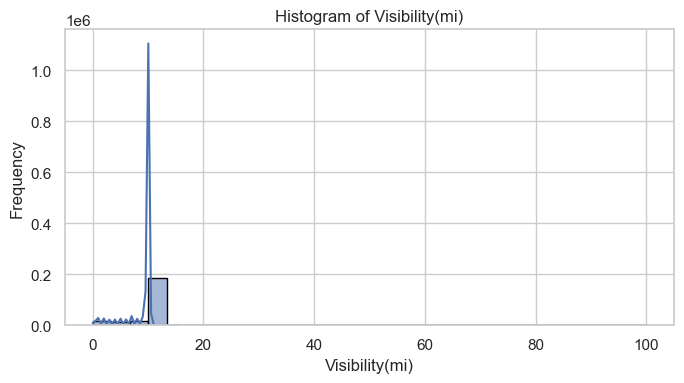

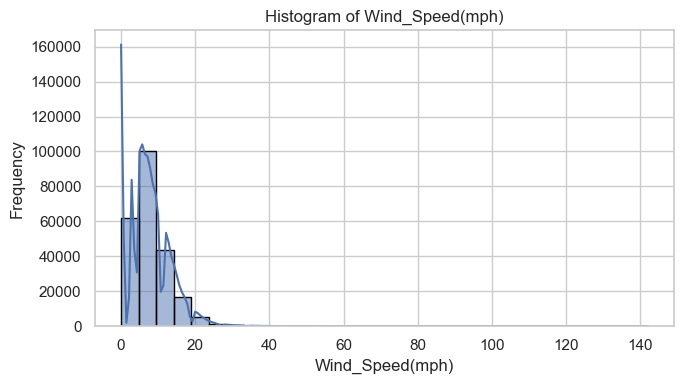

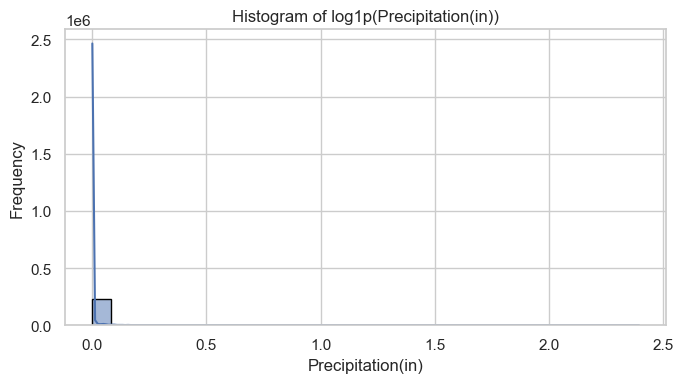

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")  # Set plot style

# Select numeric columns (int or float)
numeric_cols = accidents.select_dtypes(include=['float', 'int']).columns

# Loop through each numeric column and plot histogram
for col in numeric_cols:
    plt.figure(figsize=(7, 4))

    data = accidents[col].dropna()
    skewness = data.skew()

    if skewness > 2:
        data = np.log1p(data)
        plt.title(f'Histogram of log1p({col})')

    else:
        plt.title(f'Histogram of {col}')

    sns.histplot(data, bins=30, kde=True, edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


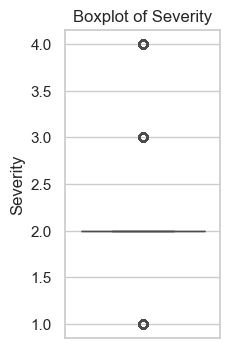

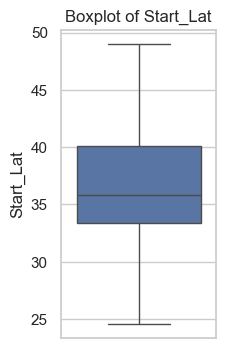

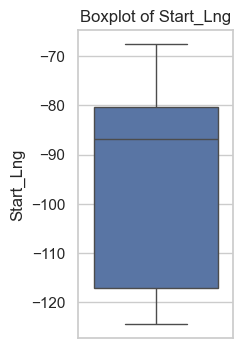

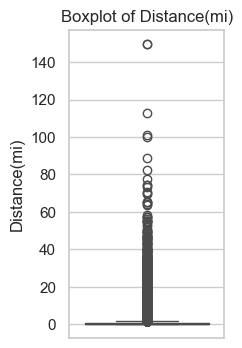

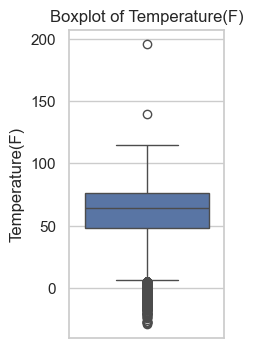

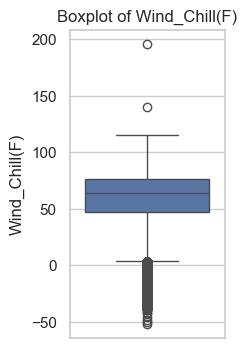

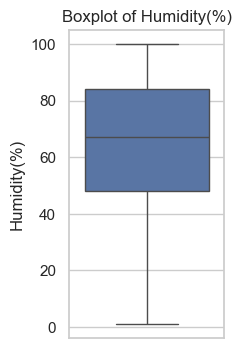

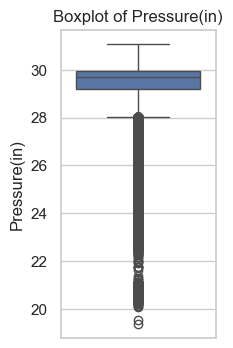

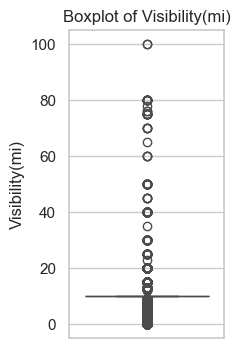

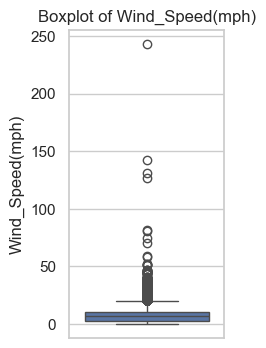

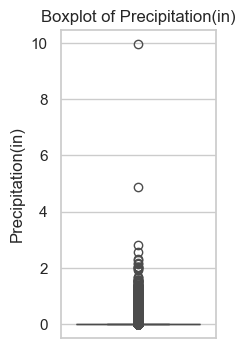

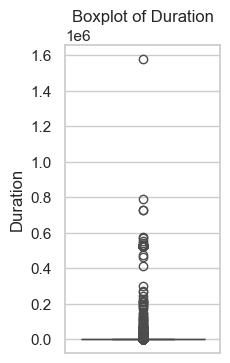

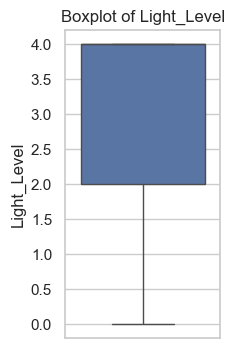

In [52]:
num_cols = accidents.select_dtypes(include=['number']).columns

for col in num_cols:
    plt.figure(figsize=(2, 4))
    sns.boxplot(y=accidents[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

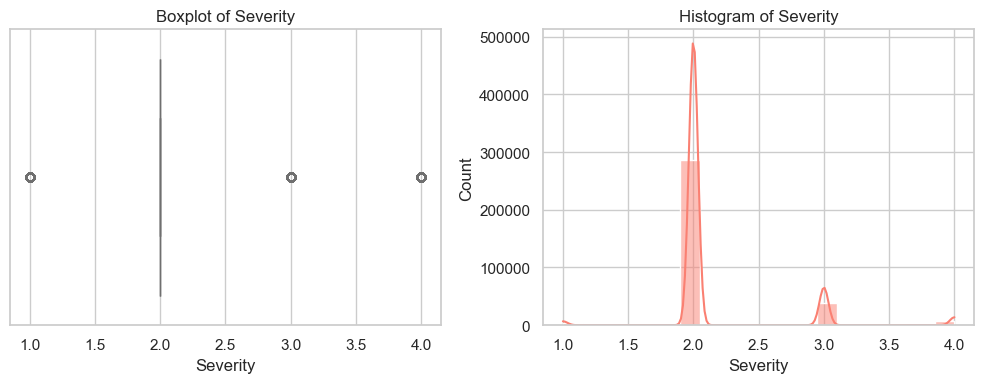

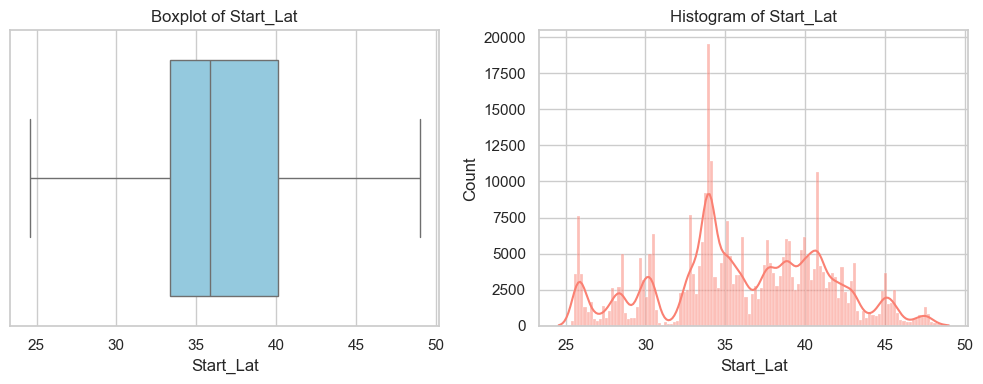

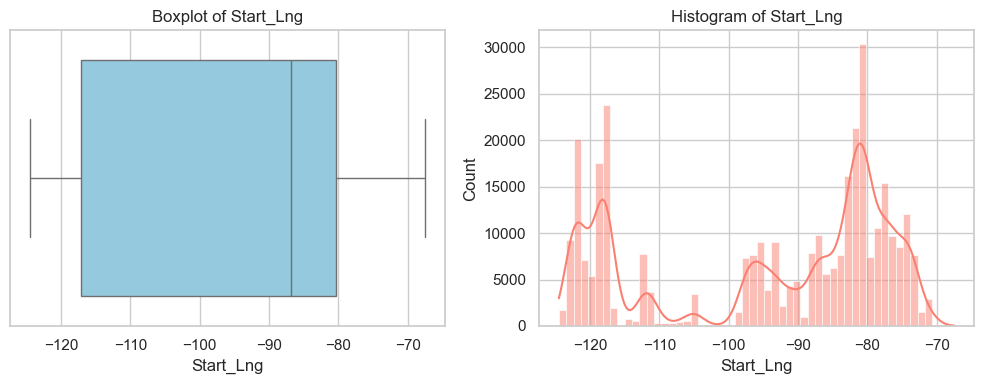

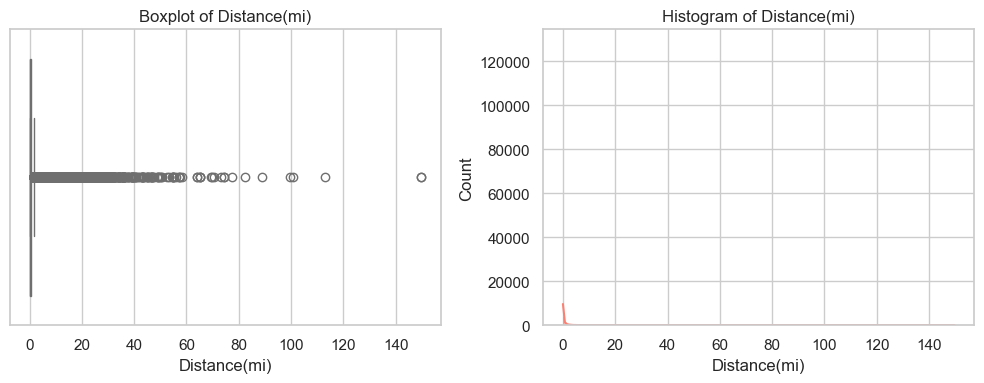

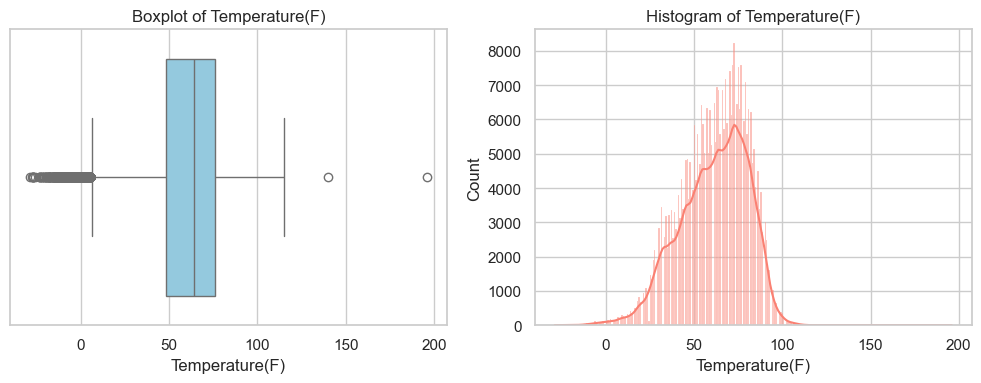

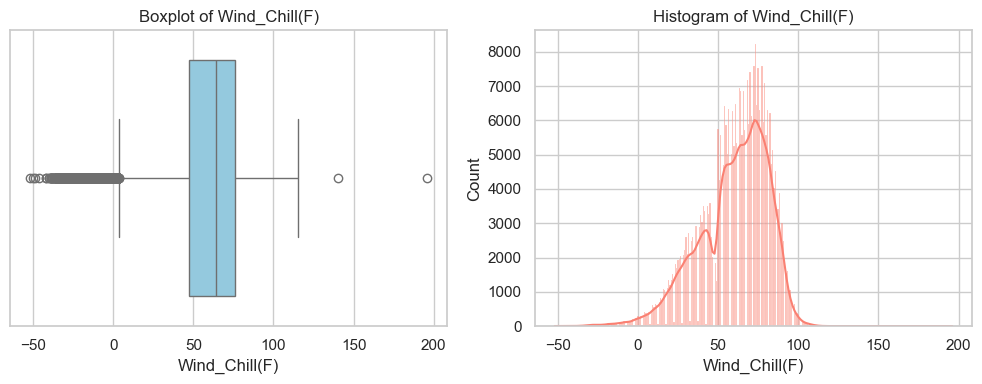

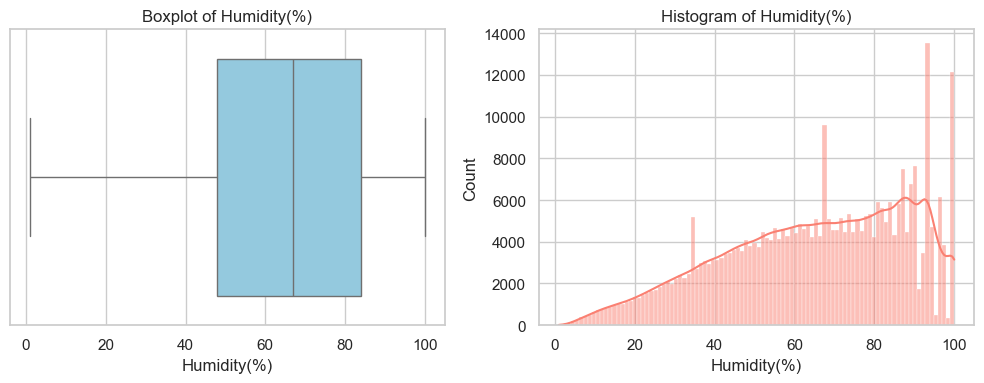

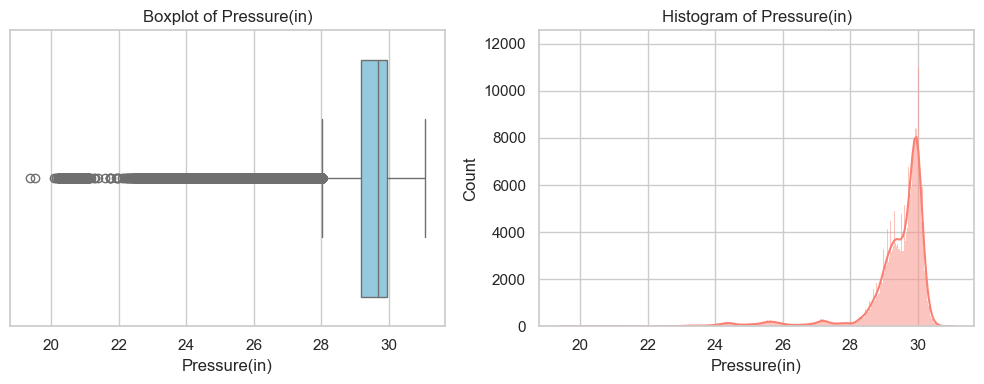

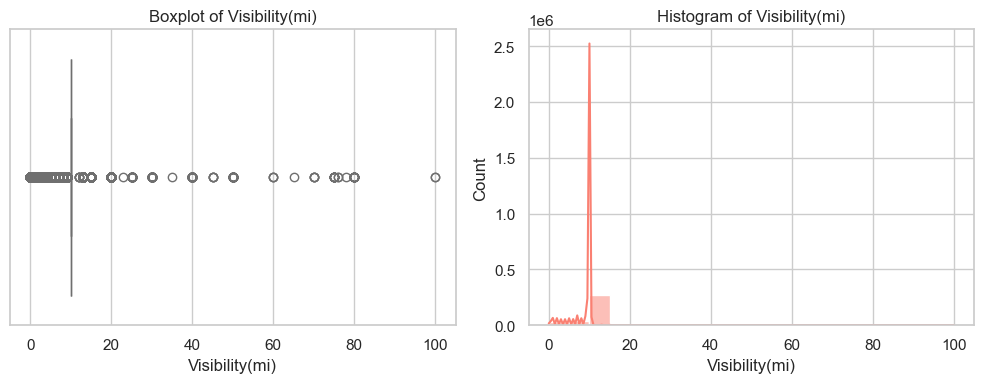

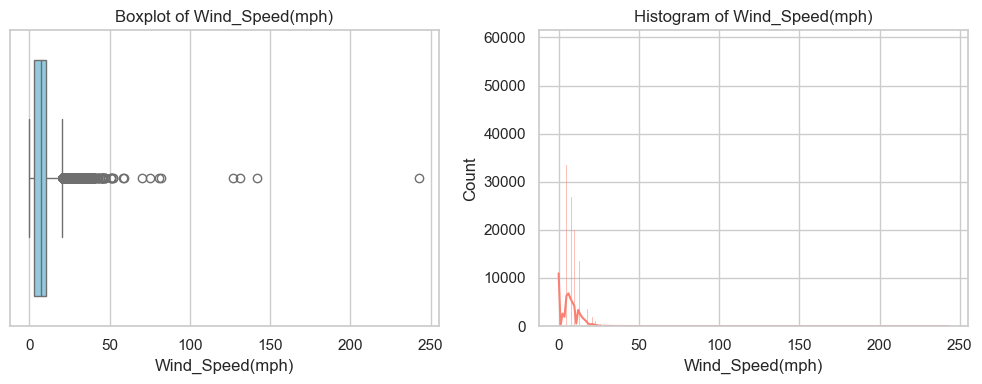

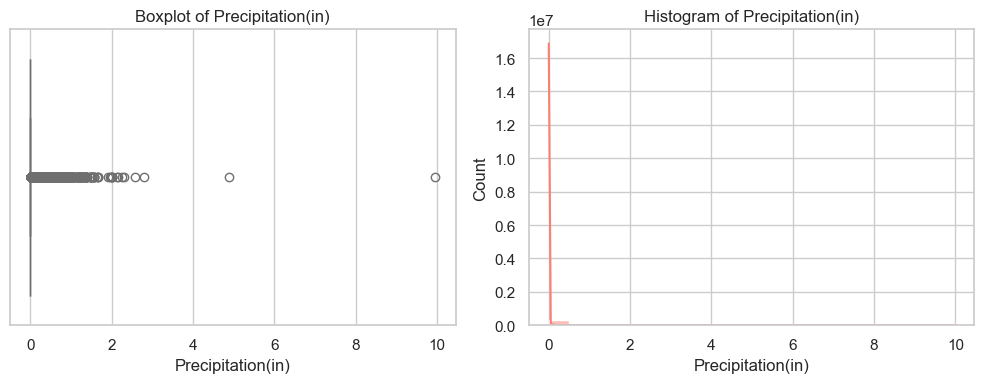

In [ ]:
num_cols = accidents.select_dtypes(include=['number']).columns

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Boxplot
    sns.boxplot(x=accidents[col], ax=axes[0], color='skyblue')
    axes[0].set_title(f"Boxplot of {col}")
    
    # Histogram
    sns.histplot(accidents[col], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"Histogram of {col}")
    
    plt.tight_layout()
    plt.show()

In [8]:

  # TODO: replace with your path
LAT_COL = "Start_Lat"
LON_COL = "Start_Lng"
SEVERITY_COL = "severity"   # optional; used for summaries if present

# Austin-ish boundary (optional): If you have a city boundary shapefile/geojson, use it here
# CITY_BOUNDARY_PATH = "austin_boundary.geojson"  # optional

# CRS choices:
CRS_WGS84 = "EPSG:4326"
# Texas Central (meters) – good for distance/area work around Austin
CRS_LOCAL = "EPSG:32139"

# DBSCAN params (in meters, because we’ll be in projected CRS)
DBSCAN_EPS_METERS = 300    # neighborhood radius (~1–3 blocks); tune as needed
DBSCAN_MIN_SAMPLES = 10

# KMeans params
KMEANS_K = 12  # start point; you can sweep k later

# Fishnet cell size for density grid
SQ_MILES = 1.0
M_PER_MILE = 1609.344
CELL_SIZE_M = (SQ_MILES ** 0.5) * M_PER_MILE  # 1x1 mile square
# ==============


# ============
# 1) Load & Clean
# ============
df = accidents.dropna(subset=[LAT_COL, LON_COL])
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[LON_COL], df[LAT_COL]),
    crs=CRS_WGS84
)

# Project to local CRS for meters / areas
gdf_m = gdf.to_crs(CRS_LOCAL)


# ============
# 2) Clustering: K-Means
# ============
X = np.vstack([gdf_m.geometry.x.values, gdf_m.geometry.y.values]).T

kmeans = KMeans(n_clusters=KMEANS_K, n_init="auto", random_state=42)
gdf_m["kmeans_cluster"] = kmeans.fit_predict(X)

# (Optional) If you want to pick K via elbow/silhouette, compute metrics over a range and choose best.

In [9]:
# ============
# 3) Clustering: DBSCAN (density-based)
# ============
db = DBSCAN(eps=DBSCAN_EPS_METERS, min_samples=DBSCAN_MIN_SAMPLES)
gdf_m["dbscan_cluster"] = db.fit_predict(X)
# Note: -1 is noise (non-clustered)

# Quick cluster summary (optionally weighted by severity if present)
def summarize_clusters(gdf, label_col):
    cols = {"count": ("geometry", "count")}
    if SEVERITY_COL in gdf.columns:
        cols["avg_severity"] = (SEVERITY_COL, "mean")
    return (
        gdf[gdf[label_col] != -1]  # exclude DBSCAN noise for summaries
          .groupby(label_col)
          .agg(**cols)
          .sort_values("count", ascending=False)
    )

kmeans_summary = summarize_clusters(gdf_m, "kmeans_cluster")
dbscan_summary = summarize_clusters(gdf_m, "dbscan_cluster")

print("\nTop K-Means clusters:")
print(kmeans_summary.head(10))
print("\nTop DBSCAN clusters:")
print(dbscan_summary.head(10))


Top K-Means clusters:
                count
kmeans_cluster       
5               33950
6               32165
3               25449
11              25198
7               23567
8               18649
0               17151
9               16411
2               14008
4               11387

Top DBSCAN clusters:
                count
dbscan_cluster       
44                992
234               787
16                755
28                520
89                465
176               346
13                324
62                297
71                293
29                273


In [10]:
# ============
# 4) GIS: Density per square mile (fishnet)
# ============
# Build a fishnet grid over the data extent
minx, miny, maxx, maxy = gdf_m.total_bounds

def make_fishnet(minx, miny, maxx, maxy, cell_size):
    x_coords = np.arange(minx, maxx + cell_size, cell_size)
    y_coords = np.arange(miny, maxy + cell_size, cell_size)

    cells = []
    for x in x_coords[:-1]:
        for y in y_coords[:-1]:
            cells.append(box(x, y, x + cell_size, y + cell_size))
    return gpd.GeoDataFrame(geometry=cells, crs=CRS_LOCAL)

grid = make_fishnet(minx, miny, maxx, maxy, CELL_SIZE_M)

# Spatial join: count points in each cell
join = gpd.sjoin(gdf_m[["geometry"]], grid, how="left", predicate="within")
counts = join.groupby("index_right").size().rename("accident_count")
grid["accident_count"] = counts
grid["accident_count"] = grid["accident_count"].fillna(0)

# Each cell is 1 sq mile (by construction)
grid["accidents_per_sq_mile"] = grid["accident_count"]  # same as count here
# If you choose a different cell size, divide by (cell_area_sq_miles)
# cell_area_sq_miles = grid.area / (M_PER_MILE**2)
# grid["accidents_per_sq_mile"] = grid["accident_count"] / cell_area_sq_miles

In [50]:
# ============
# 5) Outputs
# ============
# Back to WGS84 for web mapping or GIS export
gdf_out = gdf_m.to_crs(CRS_WGS84)
grid_out = grid.to_crs(CRS_WGS84)

# Save clustered points & density grid
gdf_out.to_file("accidents_with_clusters.geojson", driver="GeoJSON")
grid_out.to_file("accident_density_grid.geojson", driver="GeoJSON")

# Also CSV summaries
kmeans_summary.to_csv("kmeans_cluster_summary.csv")
dbscan_summary.to_csv("dbscan_cluster_summary.csv")

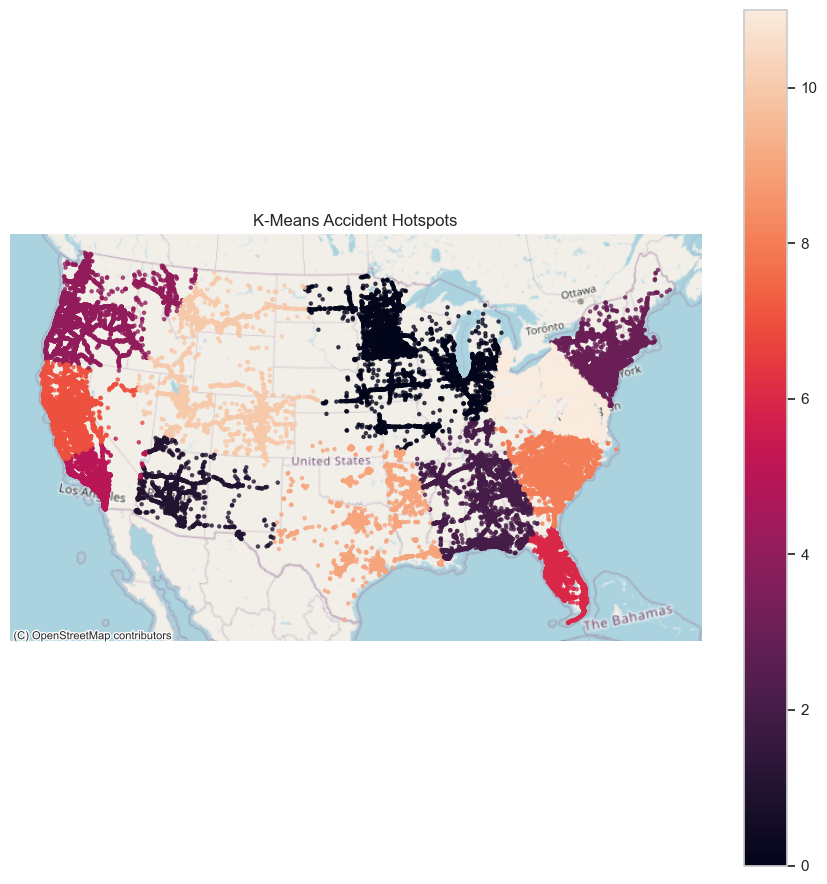

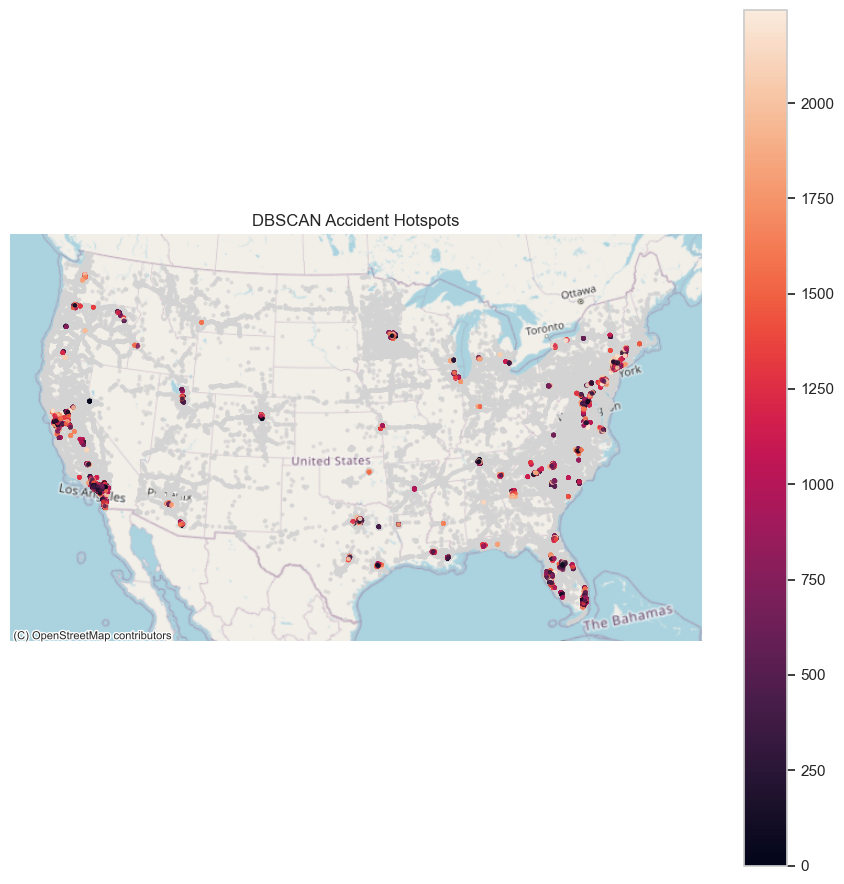

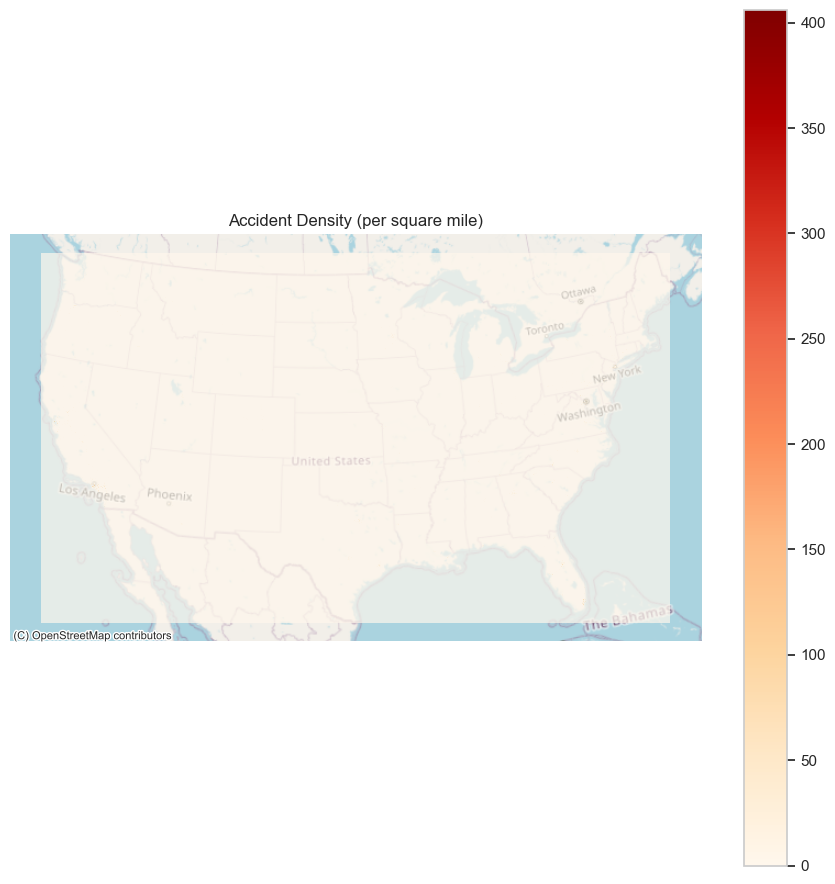

In [11]:
# ============
# 6) Quick Visuals
# ============
# KMeans map
fig, ax = plt.subplots(figsize=(9, 9))
gdf_m.plot(ax=ax, column="kmeans_cluster", markersize=5, legend=True, alpha=0.7)
ctx.add_basemap(ax, crs=gdf_m.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("K-Means Accident Hotspots")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# DBSCAN map (noise in gray)
fig, ax = plt.subplots(figsize=(9, 9))
palette = gdf_m["dbscan_cluster"].copy()
# Normalize noise to large negative color index by plotting noise separately
gdf_m[gdf_m["dbscan_cluster"] == -1].plot(ax=ax, color="lightgray", markersize=4, alpha=0.6, label="Noise")
gdf_m[gdf_m["dbscan_cluster"] != -1].plot(ax=ax, column="dbscan_cluster", markersize=5, legend=True, alpha=0.8)
ctx.add_basemap(ax, crs=gdf_m.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("DBSCAN Accident Hotspots")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Density grid (accidents per sq mile)
fig, ax = plt.subplots(figsize=(9, 9))
grid.plot(ax=ax, column="accidents_per_sq_mile", cmap="OrRd", legend=True, alpha=0.7, linewidth=0)
ctx.add_basemap(ax, crs=gdf_m.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Accident Density (per square mile)")
ax.set_axis_off()
plt.tight_layout()
plt.show()
